In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import xarray as xr
import buoy_tools as bt
from physoce import tseries as ts
from physoce import oceans as oc

# NBDC Station 46042 Data

In [2]:
# NBDC 46042
#nbdc_july = bt.nbdc_to_ds('46042_Buoy/July_met_data.txt')
#nbdc_aug = bt.nbdc_to_ds('46042_Buoy/Aug_met_data.txt')
#nbdc_sept = bt.nbdc_to_ds('46042_Buoy/Sept_met_data.txt')
datapath = 'NDBC/ndbc_46042_2022.txt'
ds = bt.ndbc_to_ds(datapath)

#Manually add ndbc metadata from their data portal
ds.attrs['Station'] = '46042'
ds.attrs['Owner'] = 'National Data Buoy Center'
ds.attrs['URL'] = 'https://www.ndbc.noaa.gov/station_page.php?station=46042'
ds.attrs['Latitude'] = 36.785
ds.attrs['Longitude'] = -122.396
ds.attrs['Air temp height'] = 3.7
ds.attrs['Anemometer height'] = 4.1
ds.attrs['Barometer elevation'] = 2.7
ds.attrs['Sea temp depth'] = -1.5
ds.attrs['Water depth'] = 1693
ds.attrs['Sample frequency'] = '10 minutes'
    
ds

<xarray.Dataset>
Dimensions:  (time: 52529)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:50:00
Data variables: (12/13)
    WDIR     (time) float64 328.0 331.0 334.0 330.0 ... 296.0 302.0 307.0 304.0
    WSPD     (time) float64 12.9 12.6 11.6 12.2 12.0 ... 11.9 13.0 13.5 14.4
    GST      (time) float64 16.1 15.5 15.1 15.6 14.4 ... 15.5 17.9 18.4 19.7
    WVHT     (time) float64 nan nan nan nan 2.98 nan ... nan nan nan 3.86 nan
    DPD      (time) float64 nan nan nan nan 8.33 nan ... nan nan nan 12.9 nan
    APD      (time) float64 nan nan nan nan 6.28 nan ... nan nan nan 7.17 nan
    ...       ...
    PRES     (time) float64 1.013e+03 1.013e+03 ... 1.001e+03 1.001e+03
    ATMP     (time) float64 11.4 11.4 11.4 11.4 11.4 ... 12.2 12.3 12.3 12.1
    WTMP     (time) float64 12.7 12.7 12.7 12.7 12.7 ... nan nan nan nan 12.5
    DEWP     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    VIS      (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    TIDE     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    Station:              46042
    Owner:                National Data Buoy Center
    URL:                  https://www.ndbc.noaa.gov/station_page.php?station=...
    Latitude:             36.785
    Longitude:            -122.396
    Air temp height:      3.7
    Anemometer height:    4.1
    Barometer elevation:  2.7
    Sea temp depth:       -1.5
    Water depth:          1693
    Sample frequency:     10 minutes

In [3]:
#Calculate wind stress magnitude from raw windspeed
from airsea import windstress as ws
z = ds.attrs['Anemometer height']
wspd = ds.WSPD.values
tau = ws.stress(wspd,z)

In [4]:
#Calculate component wind speeds and wind stresses
wdir = ds.WDIR.values*(np.pi/180) #convert wind direction to radians

#Initialize empty arrays for E/W and N/S wind speeds and wind stresses
eastSPD = np.empty(len(wspd))
northSPD = np.empty(len(wspd))

eastTau = np.empty(len(tau))
northTau = np.empty(len(tau))

for i in enumerate(wdir):
    eastSPD[i[0]] = -np.sin(i[1])*wspd[i[0]]
    northSPD[i[0]] = -np.cos(i[1])*wspd[i[0]]
    
    eastTau[i[0]] = -np.sin(i[1])*tau[i[0]]
    northTau[i[0]] = -np.cos(i[1])*tau[i[0]]

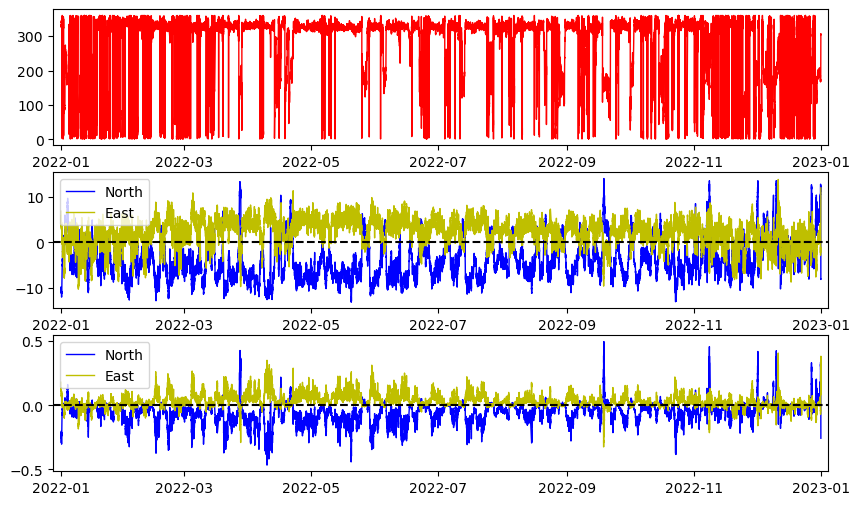

In [5]:
#Check that speeds of components match cardinal wind direction
#Keeping in mind that wind from ndbc is given in "from" direction
plt.figure(figsize=(10,6))
plt.subplot(311)
plt.plot(ds.time,ds.WDIR.values,'-r',lw=1)
plt.margins(x=.01)

plt.subplot(312)
plt.plot(ds.time,northSPD,'-b',lw=1,label = 'North')
plt.plot(ds.time,eastSPD,'-y',lw=1,label = 'East')
plt.axhline(y=0,color='black',ls='--')
plt.margins(x=.01)
plt.legend()

plt.subplot(313)
plt.plot(ds.time,northTau,'-b',lw=1,label = 'North')
plt.plot(ds.time,eastTau,'-y',lw=1,label = 'East')
plt.axhline(y=0,color='black',ls='--')
plt.margins(x=.01)
plt.legend()

In [6]:
#Rotate windspeed to primary axes
thetaSPD,majorSPD,minorSPD = ts.princax(eastSPD,northSPD)
secSPD,primSPD = ts.rot(eastSPD,northSPD,-thetaSPD-90)

thetaTau,majorTau,minorTau = ts.princax(eastTau,northTau)
secTau,primTau = ts.rot(eastTau,northTau,-thetaTau-90)

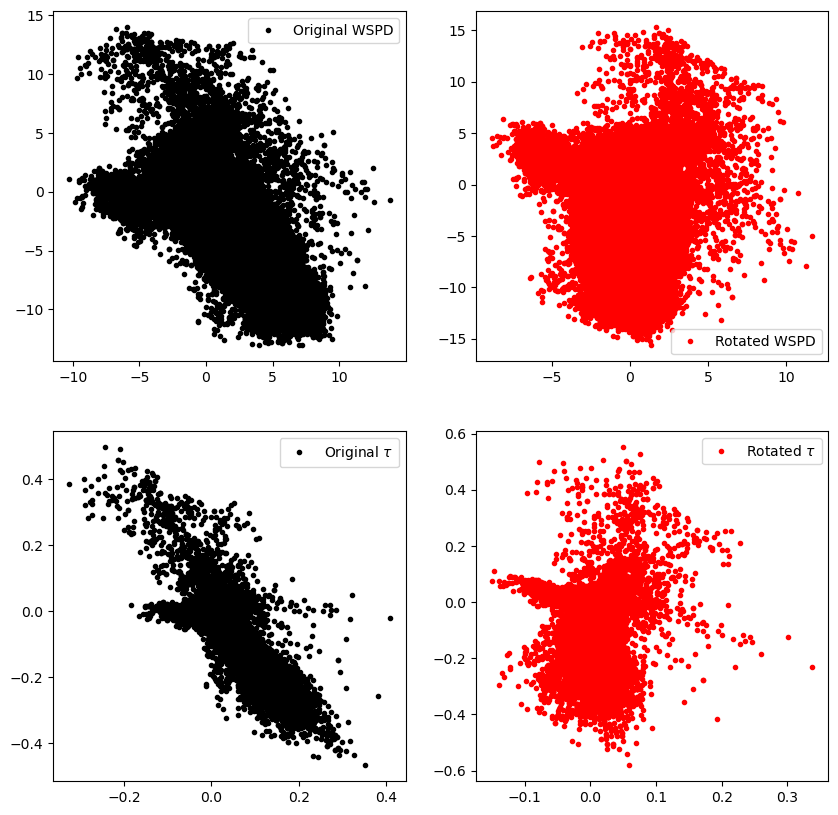

In [7]:
#Check how the wind stress and rotated coordinate systems look
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(eastSPD,northSPD,'.k',label=r'Original WSPD')
plt.legend()
plt.subplot(222)
plt.plot(secSPD,primSPD,'.r',label=r'Rotated WSPD')
plt.legend()
plt.subplot(223)
plt.plot(eastTau,northTau,'.k',lw=1,label=r'Original $\tau$')
plt.legend()

plt.subplot(224)
plt.plot(secTau,primTau,'.r',lw=1,label=r'Rotated $\tau$')
plt.legend()

In [8]:
#Add all components to the dataset
ds['WSTR'] = (['time'],tau,
              {'Description':'Eastern wind stress','Units':'$N/m^{2}$'})
ds['EastWSPD'] = (['time'],eastSPD,
                          {'Description':'Eastern wind speed','Units':'m/s'})
ds['EastWSTR'] = (['time'],eastTau,
                          {'Description':'Eastern wind stress','Units':'$N/m^{2}$'})

ds['NorthWSPD'] = (['time'],northSPD,
                          {'Description':'Eastern wind speed','Units':'m/s'})
ds['NorthWSTR'] = (['time'],northTau,
                          {'Description':'Northern wind stress','Units':'$N/m^{2}$'})

ds['PrimWSPD'] = (['time'],primSPD,
                          {'Description':'Primary component of wind speed','Direction':'Alongshore',
                           'Units':'m/s','Major Std.':majorSPD})
ds['PrimWSTR'] = (['time'],primTau,
                          {'Description':'Primary component of wind stress','Direction':'Alongshore',
                           'Units':'$N/m^{2}$','Major Std.':majorTau})

ds['SecWSPD'] = (['time'],secSPD,
                          {'Description':'Secondary component of wind speed','Direction':'Across-shore',
                           'Units':'m/s','Minor Std.':minorSPD})
ds['SecWSTR'] = (['time'],secTau,
                          {'Description':'Secondary component of wind stress','Direction':'Across-shore',
                           'Units':'$N/m^{2}$','Minor Std.':minorTau})
ds.attrs['WSPD Coordinate rotation angle'] = -thetaSPD-90
ds.attrs['WSTR Coordinate rotation angle'] = -thetaTau-90

ds

<xarray.Dataset>
Dimensions:    (time: 52529)
Coordinates:
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:50:00
Data variables: (12/22)
    WDIR       (time) float64 328.0 331.0 334.0 330.0 ... 302.0 307.0 304.0
    WSPD       (time) float64 12.9 12.6 11.6 12.2 12.0 ... 11.9 13.0 13.5 14.4
    GST        (time) float64 16.1 15.5 15.1 15.6 14.4 ... 15.5 17.9 18.4 19.7
    WVHT       (time) float64 nan nan nan nan 2.98 nan ... nan nan nan 3.86 nan
    DPD        (time) float64 nan nan nan nan 8.33 nan ... nan nan nan 12.9 nan
    APD        (time) float64 nan nan nan nan 6.28 nan ... nan nan nan 7.17 nan
    ...         ...
    NorthWSPD  (time) float64 -10.94 -11.02 -10.43 ... -6.889 -8.125 -8.052
    NorthWSTR  (time) float64 -0.288 -0.2786 -0.2287 ... -0.1838 -0.2315 -0.257
    PrimWSPD   (time) float64 -12.9 -12.58 -11.53 -12.19 ... -11.7 -12.62 -13.17
    PrimWSTR   (time) float64 -0.3396 -0.3183 -0.2535 ... -0.3095 -0.3571 -0.417
    SecWSPD    (time) float64 -0.03611 -0.6947 -1.245 ... 5.666 4.803 5.82
    SecWSTR    (time) float64 0.004951 -0.01203 -0.02291 ... 0.1566 0.1431 0.193
Attributes: (12/13)
    Station:                         46042
    Owner:                           National Data Buoy Center
    URL:                             https://www.ndbc.noaa.gov/station_page.p...
    Latitude:                        36.785
    Longitude:                       -122.396
    Air temp height:                 3.7
    ...                              ...
    Barometer elevation:             2.7
    Sea temp depth:                  -1.5
    Water depth:                     1693
    Sample frequency:                10 minutes
    WSPD Coordinate rotation angle:  -32.16039742519298
    WSTR Coordinate rotation angle:  -31.16473295588552

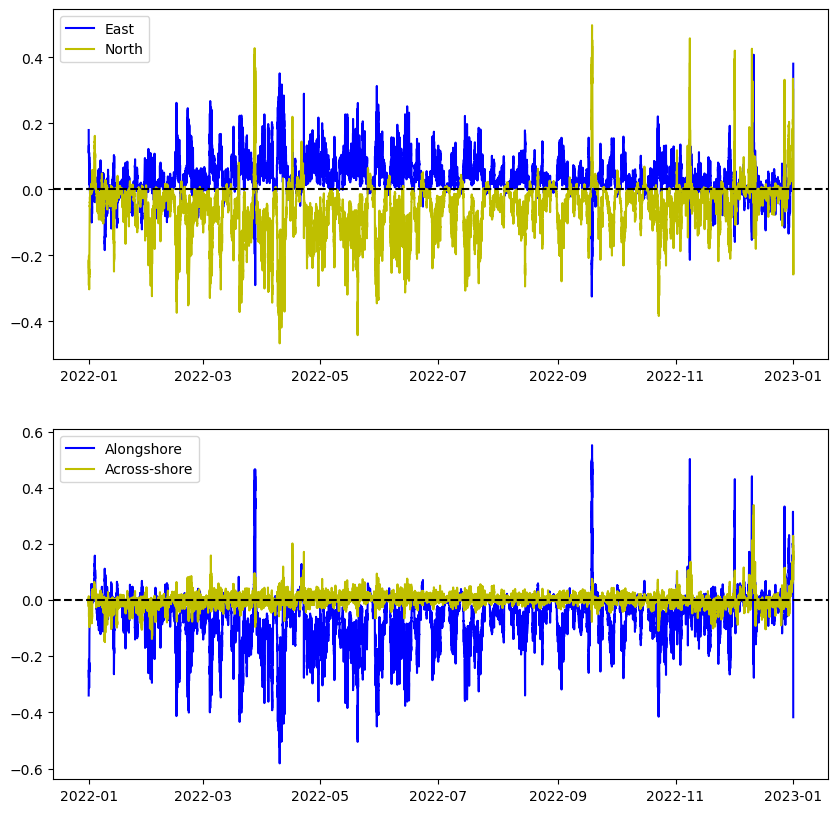

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(ds.time,ds.EastWSTR,'-b',label='East')
plt.plot(ds.time,ds.NorthWSTR,'-y',label='North')
plt.axhline(y=0,ls='--',color='black')
plt.legend()
plt.subplot(212)
plt.plot(ds.time,ds.PrimWSTR,'-b',label='Alongshore')
plt.plot(ds.time,ds.SecWSTR,'-y',label='Across-shore')
plt.axhline(y=0,ls='--',color='black')
plt.legend()

In [10]:
ds.to_netcdf('NDBC/ndbc_46042_2022.nc')

In [7]:
#Create dataset from station 46239 wave buoy data
datapath = 'NDBC/ndbc_46239_2022.txt'
ds = bt.ndbc_to_ds(datapath)

#Manually add ndbc metadata from their data portal
ds.attrs['Station'] = '46239'
ds.attrs['Owner'] = 'Scripps Institution of Oceanography'
ds.attrs['URL'] = 'https://www.ndbc.noaa.gov/station_page.php?station=46239'
ds.attrs['Latitude'] = 36.335
ds.attrs['Longitude'] = -122.104
ds.attrs['Sea temp depth'] = -0.46
ds.attrs['Water depth'] = 369
ds.attrs['Sample frequency'] = '30 minutes'

ds

<xarray.Dataset>
Dimensions:  (time: 17497)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01T00:26:00 ... 2022-12-31T23:56:00
Data variables: (12/13)
    WDIR     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    WSPD     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    GST      (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    WVHT     (time) float64 3.25 3.49 3.51 3.36 3.2 ... 3.57 3.5 3.67 3.62 3.82
    DPD      (time) float64 8.33 9.09 8.33 8.33 8.33 ... 9.88 14.29 15.38 14.29
    APD      (time) float64 6.64 6.77 6.81 6.66 6.71 ... 7.69 7.25 7.51 7.3 7.61
    ...       ...
    PRES     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ATMP     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    WTMP     (time) float64 13.2 13.2 13.2 13.2 13.2 ... 13.3 13.3 13.2 13.2
    DEWP     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    VIS      (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    TIDE     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    Station:           46239
    Owner:             Scripps Institution of Oceanography
    URL:               https://www.ndbc.noaa.gov/station_page.php?station=46239
    Latitude:          36.335
    Longitude:         -122.104
    Sea temp depth:    -0.46
    Water depth:       369
    Sample frequency:  30 minutes

In [8]:
ds.to_netcdf('46042_Buoy/ndbc_46239_2022.nc')

# M1 Mooring Data

In [3]:
m1_wind = bt.m1_1d_reshape('M1/m1_wind_raw.nc')

In [4]:
m1_wind

<xarray.Dataset>
Dimensions:                              (time: 76612)
Coordinates:
  * time                                 (time) datetime64[ns] 2022-07-21T07:...
Data variables:
    wind_speed_sonic                     (time) float64 nan nan ... 3.238 2.485
    wind_from_direction_sonic            (time) float64 nan nan ... 211.8 239.8
    wind_speed_windbird                  (time) float64 nan nan ... 0.1085
    wind_from_direction_windbird         (time) float64 nan nan ... 244.2 272.2
    wind_speed_sonic_qc_agg              (time) float64 2.0 2.0 2.0 ... 1.0 1.0
    wind_from_direction_sonic_qc_agg     (time) float64 2.0 2.0 2.0 ... 1.0 1.0
    wind_speed_windbird_qc_agg           (time) float64 2.0 2.0 2.0 ... 1.0 1.0
    wind_from_direction_windbird_qc_agg  (time) float64 2.0 2.0 2.0 ... 1.0 1.0
    z                                    (time) float64 -250.0 -225.0 ... 2.5
Attributes:
    cdm_altitude_proxy:            z
    cdm_data_type:                 TimeSeriesProfile
    cdm_profile_variables:         time
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             webmaster.ndbc@noaa.gov,cencoos_communicat...
    contributor_name:              NOAA National Data Buoy Center (NDBC),Cent...
    contributor_role:              contributor,funder,contributor,processor
    contributor_role_vocabulary:   NERC
    contributor_url:               https://www.ndbc.noaa.gov/,http://cencoos....
    Conventions:                   IOOS-1.2, CF-1.6, ACDD-1.3
    creator_country:               USA
    creator_email:                 webmaster@mbari.org
    creator_institution:           Monterey Bay Aquarium Research Institute (...
    creator_name:                  Monterey Bay Aquarium Research Institute (...
    creator_sector:                nonprofit
    creator_type:                  institution
    creator_url:                   http://www.mbari.org/
    defaultDataQuery:              northward_sea_water_velocity,wind_speed_so...
    featureType:                   TimeSeriesProfile
    geospatial_lat_units:          degrees_north
    geospatial_lon_units:          degrees_east
    geospatial_vertical_positive:  up
    geospatial_vertical_units:     m
    history:                       Downloaded from Monterey Bay Aquarium Rese...
    id:                            20716
    infoUrl:                       https://sensors.ioos.us/#metadata/20716/st...
    institution:                   Monterey Bay Aquarium Research Institute (...
    license:                       The data may be used and redistributed for...
    naming_authority:              com.axiomdatascience
    platform:                      buoy
    platform_name:                 M1 Mooring Real-Time Data, Monterey Bay, CA
    platform_vocabulary:           http://mmisw.org/ont/ioos/platform
    processing_level:              Level 2
    publisher_country:             USA
    publisher_email:               webmaster@mbari.org
    publisher_institution:         Monterey Bay Aquarium Research Institute (...
    publisher_name:                Monterey Bay Aquarium Research Institute (...
    publisher_sector:              nonprofit
    publisher_type:                institution
    publisher_url:                 http://www.mbari.org/
    references:                    http://www.mbari.org/oasis/index.html,http...
    sourceUrl:                     https://dods.mbari.org/opendap/data/ssdsda...
    standard_name_vocabulary:      CF Standard Name Table v72
    station_id:                    20716
    summary:                       Timeseries data from 'M1 Mooring Real-Time...
    time_coverage_end:             2022-09-09T06:51:00Z
    time_coverage_start:           2022-07-21T07:00:00Z
    title:                         M1 Mooring Real-Time Data, Monterey Bay, CA
    wmo_platform_code:             46092

In [45]:
# M1 mooring data

# Use by.m1_nc_reshape to create data arrays that are 2d instead of one
# 2d arrays are much easier to plot
m1_ns = bt.m1_2d_reshape('M1/m1_northward_raw.nc')
m1_ew = bt.m1_2d_reshape('M1/m1_eastward_raw.nc')
#m1_temp = bt.m1_2d_reshape('M1/m1_temp_raw.nc')
m1_temp = xr.open_dataset('M1/m1_temp_raw.nc')

# This data 1d, and doesn't require the z dimension
m1_wind = bt.m1_1d_reshape('M1/m1_wind_raw.nc')

In [47]:
m1_wind

<xarray.Dataset>
Dimensions:                              (time: 76612)
Coordinates:
  * time                                 (time) datetime64[ns] 2022-07-21T07:...
Data variables:
    wind_speed_sonic                     (time) float64 nan nan ... 3.238 2.485
    wind_from_direction_sonic            (time) float64 nan nan ... 211.8 239.8
    wind_speed_windbird                  (time) float64 nan nan ... 0.1085
    wind_from_direction_windbird         (time) float64 nan nan ... 244.2 272.2
    wind_speed_sonic_qc_agg              (time) float64 2.0 2.0 2.0 ... 1.0 1.0
    wind_from_direction_sonic_qc_agg     (time) float64 2.0 2.0 2.0 ... 1.0 1.0
    wind_speed_windbird_qc_agg           (time) float64 2.0 2.0 2.0 ... 1.0 1.0
    wind_from_direction_windbird_qc_agg  (time) float64 2.0 2.0 2.0 ... 1.0 1.0
    z                                    (time) float64 -250.0 -225.0 ... 2.5
Attributes:
    cdm_altitude_proxy:            z
    cdm_data_type:                 TimeSeriesProfile
    cdm_profile_variables:         time
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             webmaster.ndbc@noaa.gov,cencoos_communicat...
    contributor_name:              NOAA National Data Buoy Center (NDBC),Cent...
    contributor_role:              contributor,funder,contributor,processor
    contributor_role_vocabulary:   NERC
    contributor_url:               https://www.ndbc.noaa.gov/,http://cencoos....
    Conventions:                   IOOS-1.2, CF-1.6, ACDD-1.3
    creator_country:               USA
    creator_email:                 webmaster@mbari.org
    creator_institution:           Monterey Bay Aquarium Research Institute (...
    creator_name:                  Monterey Bay Aquarium Research Institute (...
    creator_sector:                nonprofit
    creator_type:                  institution
    creator_url:                   http://www.mbari.org/
    defaultDataQuery:              northward_sea_water_velocity,wind_speed_so...
    featureType:                   TimeSeriesProfile
    geospatial_lat_units:          degrees_north
    geospatial_lon_units:          degrees_east
    geospatial_vertical_positive:  up
    geospatial_vertical_units:     m
    history:                       Downloaded from Monterey Bay Aquarium Rese...
    id:                            20716
    infoUrl:                       https://sensors.ioos.us/#metadata/20716/st...
    institution:                   Monterey Bay Aquarium Research Institute (...
    license:                       The data may be used and redistributed for...
    naming_authority:              com.axiomdatascience
    platform:                      buoy
    platform_name:                 M1 Mooring Real-Time Data, Monterey Bay, CA
    platform_vocabulary:           http://mmisw.org/ont/ioos/platform
    processing_level:              Level 2
    publisher_country:             USA
    publisher_email:               webmaster@mbari.org
    publisher_institution:         Monterey Bay Aquarium Research Institute (...
    publisher_name:                Monterey Bay Aquarium Research Institute (...
    publisher_sector:              nonprofit
    publisher_type:                institution
    publisher_url:                 http://www.mbari.org/
    references:                    http://www.mbari.org/oasis/index.html,http...
    sourceUrl:                     https://dods.mbari.org/opendap/data/ssdsda...
    standard_name_vocabulary:      CF Standard Name Table v72
    station_id:                    20716
    summary:                       Timeseries data from 'M1 Mooring Real-Time...
    time_coverage_end:             2022-09-09T06:51:00Z
    time_coverage_start:           2022-07-21T07:00:00Z
    title:                         M1 Mooring Real-Time Data, Monterey Bay, CA
    wmo_platform_code:             46092

In [48]:
m1_ns.to_netcdf('M1/m1_ns.nc')
m1_ew.to_netcdf('M1/m1_ew.nc')
m1_temp.to_netcdf('M1/m1_temp.nc')
m1_wind.to_netcdf('M1/m1_wind.nc')

In [8]:
m1_nw.northward_sea_water_velocity.attrs['actual_range']

{'_ChunkSizes': 512,
 'actual_range': [<xarray.DataArray 'northward_sea_water_velocity' ()>
  array(-2.42679079),
  <xarray.DataArray 'northward_sea_water_velocity' ()>
  array(5.76483912)],
 'ancillary_variables': 'northward_sea_water_velocity_qc_agg northward_sea_water_velocity_qc_tests',
 'id': '1028899',
 'ioos_category': 'Other',
 'long_name': 'Northward Sea Water Velocity',
 'platform': 'station',
 'short_name': 'northward_sea_water_velocity',
 'standard_name': 'northward_sea_water_velocity',
 'standard_name_url': 'http://mmisw.org/ont/cf/parameter/northward_sea_water_velocity',
 'units': 'm.s-1'}

<ipython-input-23-d70c5524e011>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(m1_nw.time, m1_nw.z, m1_nw.northward_sea_water_velocity.T,norm=norm)


Text(0, 0.5, 'Altitude (meters)')

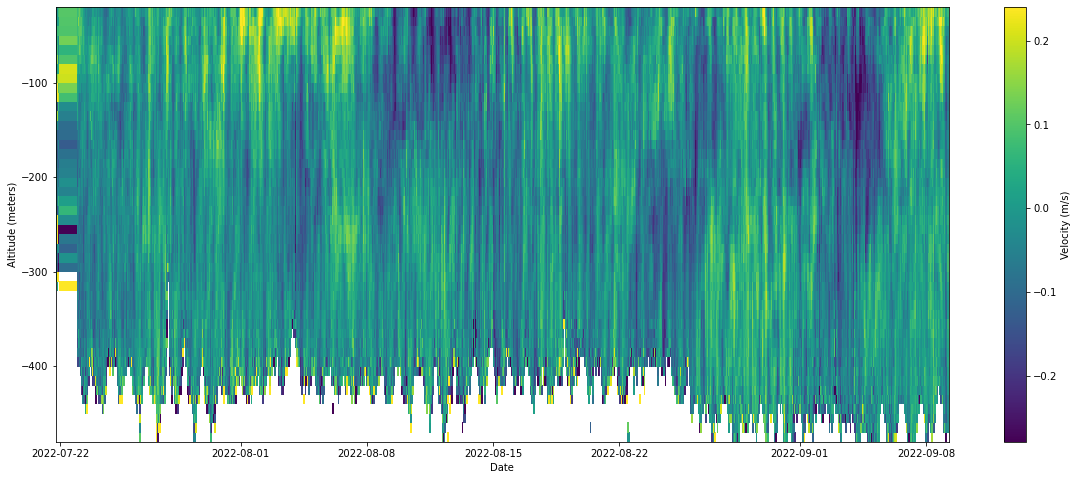

In [23]:
plt.figure(figsize = (20,8))
# 1 knot is 0.514444 m/s
minvel = min  # Limits for the colorbars used on the adcp colorplots
maxvel = max
norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)
plt.pcolormesh(m1_nw.time, m1_nw.z, m1_nw.northward_sea_water_velocity.T,norm=norm)
plt.colorbar(label='Velocity (m/s)')
plt.xlabel('Date')
plt.ylabel('Altitude (meters)')

<ipython-input-30-b9bcd620d6f8>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(m1_temp.time, m1_temp.z, m1_temp.sea_water_temperature.T,norm=norm)


Text(0, 0.5, 'Altitude (meters)')

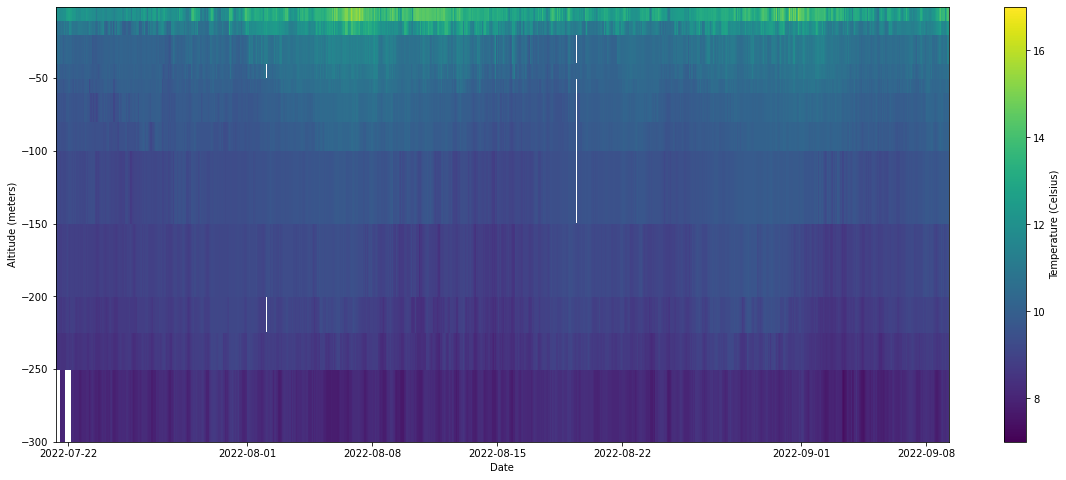

In [30]:
plt.figure(figsize = (20,8))
mintemp = 7#np.mean(m1_temp.sea_water_temperature) - (np.std(m1_temp.sea_water_temperature) * 3)  # Limits for the colorbars used on the adcp colorplots
maxtemp = 17#np.mean(m1_temp.sea_water_temperature) + (np.std(m1_temp.sea_water_temperature) * 3)
norm = matplotlib.colors.Normalize(vmin=mintemp,vmax=maxtemp)
plt.pcolormesh(m1_temp.time, m1_temp.z, m1_temp.sea_water_temperature.T,norm=norm)
plt.colorbar(label='Temperature (Celsius)')
plt.xlabel('Date')
plt.ylabel('Altitude (meters)')